- check if multiple bands work 
- mess with galaxy galaxy to make image clearer
- look at noise

## Supernovae population for the Roman survey
In this notebook, we simulate population of lensed supernovae for the Roman survey and simulate image of a 

random lensed supernovae. It follows following steps:

1. Simulate lensed supernovae population
2. Choose a lens at random
3. Set observation time and other image configuration
4. Simulate image of a selected lens
5. Visualize it

Before running this notebook, please download the download psfs from cached_webb_psf
(https://github.com/LSST-strong-lensing/data_public/webbpsf), where the
psfs have been generated ahead of time so that they can be loaded from a file.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import slsim
from slsim.Lenses.lens_pop import LensPop
from slsim.Pipelines.roman_speclite import configure_roman_filters
from slsim.Pipelines.roman_speclite import filter_names
import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
import corner
import time

from slsim.ImageSimulation.image_simulation import point_source_coordinate_properties
from slsim.Plots.plot_functions import create_image_montage_from_image_list
from slsim.ImageSimulation.roman_image_simulation import lens_image_roman

/global/homes/e/emlin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Roman configurations

In [2]:
# Import default Roman Space Telescope configuration
path = os.path.dirname(slsim.__file__)
module_path, _ = os.path.split(path)
skypy_config = os.path.join(module_path, "data/SkyPy/roman-like.yml")

# generate Roman filters
configure_roman_filters()

# import filter bands and make them recogniable in speclite
roman_filters = filter_names()
# filters are ['Roman-F062', 'Roman-F087', 'Roman-F106', 'Roman-F129', 'Roman-F158', 'Roman-F184', 'Roman-F146', 'Roman-F213']

speclite.filters.load_filters(
    roman_filters[0],
    roman_filters[1],
    roman_filters[2],
    roman_filters[3],
    roman_filters[4],
    roman_filters[5],
    roman_filters[6],
    roman_filters[7],
)

## Simulate lensed supernovae population

In [3]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
deflector_sky_area = Quantity(value=.05, unit="deg2")
source_sky_area = Quantity(value=.10, unit="deg2")
host_sky_area = Quantity(value=.02, unit="deg2")
sky_area = Quantity(value=100, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_deflector_cut = {"band": "F062", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"z_min": 0.01, "z_max": 5}

time_range = np.linspace(-50, 500, 550)
modeldir = "/Users/narayankhadka/Downloads/sncosmo_sn_models/SALT3.NIR_WAVEEXT/"

In [4]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=skypy_config, sky_area=deflector_sky_area, filters=None, cosmo=cosmo
)

In [5]:
# generate galaxy population using skypy pipeline for host galaxies. These galaxies will
#  be used as host galaxy candidates.
galaxy_simulation_pipeline_host = pipelines.SkyPyPipeline(
    skypy_config=skypy_config, sky_area=host_sky_area, filters=None, cosmo=cosmo
)

In [6]:
# Initiate deflector population class
lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=deflector_sky_area,
)

/pscratch/sd/e/emlin/lensedsupernovae/slsim/slsim/Deflectors/DeflectorPopulation/elliptical_lens_galaxies.py:48: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


In [7]:
start = time.time()

# generate supernovae population
supernovae_catalog = sources.SupernovaeCatalog.SupernovaeCatalog(
    sn_type="Ia",
    band_list=["F184", "F129", "F062"],
    lightcurve_time=time_range,
    absolute_mag_band="bessellb",
    absolute_mag=None,
    mag_zpsys="ab",
    cosmo=cosmo,
    skypy_config=skypy_config,
    sky_area=source_sky_area,
    host_galaxy_candidate=galaxy_simulation_pipeline_host.blue_galaxies,
)
supernovae_data = supernovae_catalog.supernovae_catalog(
    host_galaxy=True, lightcurve=False
)

end = time.time()
print(f"Execution time: {end - start:.2f} seconds")


/pscratch/sd/e/emlin/lensedsupernovae/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  numerator = integrate.quad(
/pscratch/sd/e/emlin/lensedsupernovae/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  numerator = integrate.quad(
/pscratch/sd/e/emlin/lensedsupernovae/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The integral is probably

Execution time: 15.31 seconds


In [8]:
print(type(supernovae_data))

<class 'astropy.table.table.Table'>


In [9]:
from astropy.table import vstack

# combine your list of Astropy tables
combined = vstack(supernovae_data)

# save to your scratch space (fast, big, temporary)
combined.write("/pscratch/sd/e/emlin/supernovae_catalog.fits", overwrite=True)

# or to $HOME if you want persistence but less space
# combined.write("/global/homes/e/emlin/supernovae_catalog.fits", overwrite=True)

In [10]:
from astropy.table import Table
catalog = Table.read("/pscratch/sd/e/emlin/supernovae_catalog.fits")



In [11]:
kwargs_sn = {
    "variability_model": "light_curve",
    "kwargs_variability": {"supernovae_lightcurve", "F184", "F129", "F062"},
    "sn_type": "Ia",
    "sn_absolute_mag_band": "bessellb",
    "sn_absolute_zpsys": "ab",
    "lightcurve_time": np.linspace(-50, 100, 150),
    "sn_modeldir": None,
}

In [12]:
source_SNIa = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=catalog,
    cosmo=cosmo,
    sky_area=source_sky_area,
    kwargs_cut={},
    catalog_type="skypy",
    source_size=None,
    extended_source_type='single_sersic'
)

In [13]:
# Initiate LensPop class
lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_SNIa,
    cosmo=cosmo,
    sky_area=sky_area,
)

In [14]:
start = time.time()

# Draw lens population
kwargs_lens_cut = {"min_image_separation": 0.1, "max_image_separation": 10}
lens_population = lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cut, speed_factor=10
)

end = time.time()
print(f"Execution time: {end - start:.2f} seconds")

Execution time: 37.95 seconds


In [15]:
print("Number of lenses:", len(lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius[0]
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift_list[0]
    source_mag = min(gg_lens.point_source_magnitude(band="F129", lensed=True)[0])
    deflector_mag = gg_lens.deflector_magnitude(band="F129")
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 145


/tmp/ipykernel_1163284/2340982460.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  source_mag = min(gg_lens.point_source_magnitude(band="F129", lensed=True)[0])


In [16]:
lens_sample_numeric = []

for i, row in enumerate(lens_samples):
    try:
        # Replace empty arrays with NaN
        new_row = [x if not isinstance(x, np.ndarray) else np.nan for x in row]
        # Convert all elements to float
        new_row = [float(x) for x in new_row]
        # Append to the list
        lens_sample_numeric.append(new_row)
    except Exception as e:
        print(f"Row {i} cannot convert to float: {row}, error: {e}")

# Convert to NumPy array for further processing
lens_sample_numeric = np.array(lens_sample_numeric)
print(lens_sample_numeric)

[[2.24669308e+02 1.15077430e+01 9.84613515e-01 ... 1.93473237e+00
             nan 1.80290070e+01]
 [1.93288124e+02 1.14308958e+01 5.87939244e-01 ... 2.69751244e+00
             nan 1.98799013e+01]
 [2.25769580e+02 1.15094729e+01 2.78458459e-01 ... 1.94928274e+00
             nan 2.16599871e+01]
 ...
 [1.32273161e+02 1.08685281e+01 3.53141876e-01 ... 1.70688782e+00
             nan 1.93621974e+01]
 [1.48647431e+02 1.10585343e+01 3.46945208e-01 ... 3.00141676e+00
             nan 2.13127165e+01]
 [1.24670200e+02 1.06744426e+01 1.43771257e-01 ... 2.00696242e+00
             nan 2.28932311e+01]]


In [17]:
## clean the population. It removes supernovae with nan value for magnitude.
cleaned_data = lens_sample_numeric[~np.isnan(lens_sample_numeric).any(axis=1)]

In [18]:
arr = np.array(lens_sample_numeric)
print("Original shape:", arr.shape)
print("Transposed shape:", arr.T.shape)

Original shape: (145, 7)
Transposed shape: (7, 145)


In [19]:
# Keep columns that have at least one valid number
mask = ~np.all(np.isnan(lens_sample_numeric) | np.isinf(lens_sample_numeric), axis=0)
data_cleaned = lens_sample_numeric[:, mask]

print("New shape after removing bad columns:", data_cleaned.shape)

New shape after removing bad columns: (145, 6)


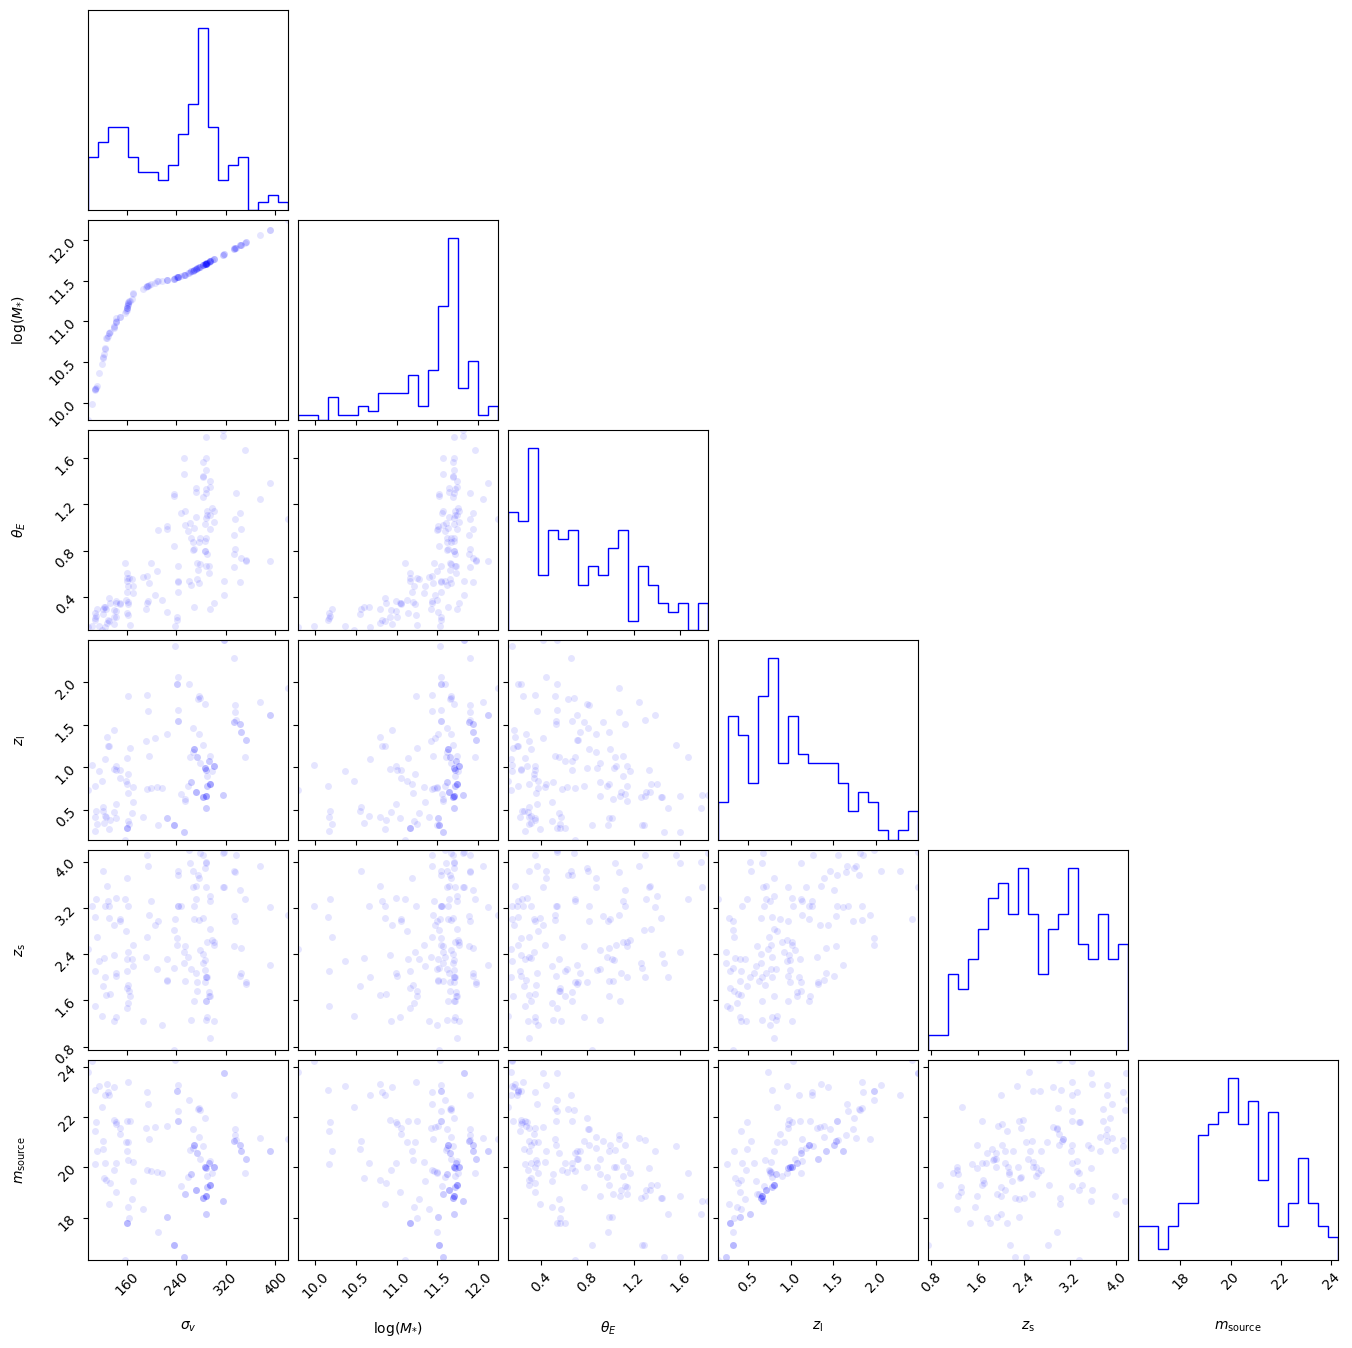

In [20]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
# corner.corner(np.array(cleaned_data), labels=labels, **hist2dkwargs)
corner.corner(np.array(data_cleaned), labels=labels, **hist2dkwargs)
plt.show()

## Choose a random lens

In [21]:
lens_class = lens_population[69]

ValueError: x and y must have same first dimension, but have shapes (500,) and (0,)

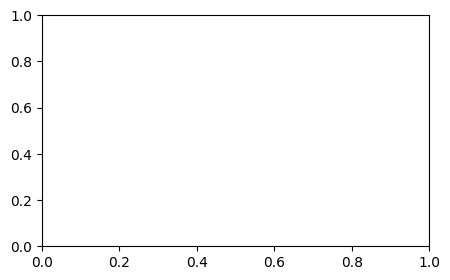

In [22]:
time = np.linspace(-50, 500, 500)
# light_curve = lens_class_test.source[0].variability_class.kwargs_model

# print("This is a type", lens_class.source().sn_type, "SN")
magnitude = lens_class.point_source_magnitude(band="F062", lensed=True, time=time)

plt.figure(figsize=(5, 3))
plt.plot(time, magnitude[0][1], label="Image 1")
plt.plot(time, magnitude[0][1], label="Image 2")
plt.gca().invert_yaxis()
plt.ylabel(r"$Mag\_{F129}$")
plt.xlabel("Time [days]")
plt.xlim(-50, 500)
plt.legend()

In [ ]:
print(lens_class.point_source_magnitude(band="F129", lensed=True, time=time))

## Simulate images 

In [ ]:
time = np.array([-25, 0, 50, 80, 90, 100, 125, 150, 200, 250])
time_series_images = []
for t in time:
    image_roman = lens_image_roman(
        lens_class=lens_class,
        band="F129",
        mag_zero_point=27,
        num_pix=71,
        transform_pix2angle=np.array([[0.11, 0], [0, 0.11]]),
        detector=1,
        detector_pos=(2000, 2000),
        oversample=5,
        psf_directory="/pscratch/sd/e/emlin/lensedsupernovae/data_public/webbpsf/cached_webb_psf",  # replace this path
        # with the path where you have downloaded webbpsf.
        t_obs=t,
        with_source=False,
        with_deflector=True,
        ra=30,
        dec=-30,
        add_noise=False,
        poisson_noise=False,
        seed=None,
    )
    time_series_images.append(image_roman)

In [ ]:
pix_coord = point_source_coordinate_properties(
    lens_class=lens_class,
    band="F184",
    mag_zero_point=27,
    delta_pix=0.11,
    num_pix=71,
    transform_pix2angle=np.array([[0.11, 0], [0, 0.11]]),
)["image_pix"]

In [ ]:
image_montage = create_image_montage_from_image_list(
    num_rows=3,
    num_cols=5,
    images=time_series_images,
    time=time,
    image_center=pix_coord,
)

In [ ]:
times = np.linspace(-50, 500, 500)
# light_curve = lens_class.source().variability_class.kwargs_model

# print("This is a type", lens_class.source().sn_type, "SN")
magnitude = lens_class.point_source_magnitude(band="F062", lensed=True, time=times)

plt.figure(figsize=(5, 3))
plt.plot(times, magnitude[0][0], label="Image 1")
plt.plot(times, magnitude[0][1], label="Image 2")
plt.gca().invert_yaxis()
plt.ylabel(r"$Mag\_{F129}$")
plt.xlabel("Time [days]")
plt.xlim(-50, 500)
plt.legend()

In [ ]:
sample_times = np.array([-50, -25, 0, 50, 75, 
                         100, 125, 150, 175, 200, 
                         225, 250, 275, 300, 325])

def make_time_series(with_source, with_deflector):
    """Generate list of images across time for given source/deflector flags."""
    time_series_images = []
    for t in sample_times:
        image_roman = lens_image_roman(
            lens_class=lens_class,
            band="F129",
            mag_zero_point=27,
            num_pix=71,
            transform_pix2angle=np.array([[0.11, 0], [0, 0.11]]),
            detector=1,
            detector_pos=(2000, 2000),
            oversample=5,
            psf_directory="/pscratch/sd/e/emlin/lensedsupernovae/data_public/webbpsf/cached_webb_psf",  # replace this path
            # with the path where you have downloaded webbpsf.
            t_obs=t,
            with_source=with_source,
            with_deflector=with_deflector,
            ra=30,
            dec=-30,
            add_noise=False,
            poisson_noise=False,
            seed=None,
        )
        time_series_images.append(image_roman)
    return time_series_images

images_both   = make_time_series(with_source=True,  with_deflector=True)
images_deflector    = make_time_series(with_source=False, with_deflector=True)
images_source    = make_time_series(with_source=True,  with_deflector=False)
images_sub    = [img_b - img_d for img_b, img_d in zip(images_both, images_deflector)]


pix_coord = point_source_coordinate_properties(
    lens_class=lens_class,
    band="F184",
    mag_zero_point=27,
    delta_pix=0.11,
    num_pix=71,
    transform_pix2angle=np.array([[0.11, 0], [0, 0.11]]),
)["image_pix"]


figures = []
titles = [
    "1. Source=True, Deflector=True",
    "2. Source=False, Deflector=True",
    "3. Source=True, Deflector=False",
    "4. Source Only (Both - Deflector)"
]
images = [images_both, images_deflector, images_source, images_sub]

for title, imgs in zip(titles, images):
    fig = create_image_montage_from_image_list(
        num_rows=3,
        num_cols=5,
        images=imgs,
        time=sample_times,
        image_center=pix_coord,
    )

    fig.suptitle(title, fontsize=16, y=1.02)
    fig.subplots_adjust(top=0.95)  
    figures.append(fig)